In [1]:
import numpy as np
import pandas as pd

In [3]:
useful_genes=pd.read_csv('useful_genes_filtered.csv')
human=pd.read_csv('human_data.csv')
gorilla=pd.read_csv('gorilla_data.csv')
chimp=pd.read_csv('chimp_data.csv')
human_filtered=human[human['Unnamed: 0'].isin(useful_genes['0'])]
gorilla_filtered=human[human['Unnamed: 0'].isin(useful_genes['0'])]
chimp_filtered=chimp[chimp['Unnamed: 0'].isin(useful_genes['0'])]

In [4]:
useful_genes=pd.read_csv('useful_genes_filtered.csv')
human=pd.read_csv('human_filtered.csv')
gorilla=pd.read_csv('gorilla_filtered.csv')
chimp=pd.read_csv('chimp_filtered.csv')
evolutional_genes=useful_genes[useful_genes['10']=='Diverged_in_both']['0'].values
non_evolutional_genes=useful_genes[useful_genes['10']=='Diverged_in_single-cell']['0'].values
human_evolutional=human[human['Unnamed: 0'].isin(evolutional_genes)]
gorilla_evolutional=gorilla[gorilla['Unnamed: 0'].isin(evolutional_genes)]
chimp_evolutional=chimp[chimp['Unnamed: 0'].isin(evolutional_genes)]

human_non_evolutional=human[human['Unnamed: 0'].isin(non_evolutional_genes)]
gorilla_non_evolutional=gorilla[gorilla['Unnamed: 0'].isin(non_evolutional_genes)]
chimp_non_evolutional=chimp[chimp['Unnamed: 0'].isin(non_evolutional_genes)]



human_evolutional_array=human_evolutional.values[:,2:].T
std_values = np.std(human_evolutional_array.astype(float), axis=0)
indices=np.argsort(std_values)[-15:]
evolutional_genes_15=evolutional_genes[indices]



gorilla_non_evolutional_array=gorilla_non_evolutional.values[:,2:].T
chimp_non_evolutional_array=chimp_non_evolutional.values[:,2:].T
std_values_non_evolutional=np.std(np.vstack((gorilla_non_evolutional_array, chimp_non_evolutional_array)).astype(float), axis=0)
indices_non_evolutional=np.argsort(std_values_non_evolutional)[-15:]
non_evolutional_genes_15=non_evolutional_genes[indices_non_evolutional]


genes_name_first_15_evolutional=np.vstack((evolutional_genes_15.reshape(-1,1), non_evolutional_genes_15.reshape(-1,1)))
genes_name_first_15_evolutional=genes_name_first_15_evolutional.reshape(-1)


human_30=human[human['Unnamed: 0'].isin(genes_name_first_15_evolutional)].T.iloc[1:,:]
gorilla_30=gorilla[gorilla['Unnamed: 0'].isin(genes_name_first_15_evolutional)].T.iloc[1:,:]
chimp_30=chimp[chimp['Unnamed: 0'].isin(genes_name_first_15_evolutional)].T.iloc[1:,:]


# Reset the index
human_30.rename(columns=human_30.iloc[0,:], inplace=True)
human_30.drop(human_30.index[0],inplace=True)  
gorilla_30.rename(columns=gorilla_30.iloc[0,:], inplace=True)
gorilla_30.drop(gorilla_30.index[0],inplace=True)
chimp_30.rename(columns=chimp_30.iloc[0,:], inplace=True)
chimp_30.drop(chimp_30.index[0],inplace=True)



primate=pd.concat([gorilla_30,chimp_30], axis=0)
# primate.to_csv('Y.csv')
# human_30.to_csv('X.csv')

In [7]:
genes_name_first_15_evolutional[15:]

array(['LUC7L3', 'RBKS', 'RBM7', 'AP4S1', 'CLCN1', 'CLASP1', 'ADTRP',
       'CNNM3', 'NDUFAF7', 'CNIH4', 'RPUSD2', 'NELFCD', 'RPP14', 'ROMO1',
       'RNF181'], dtype=object)

In [2]:
from helper_functions import *
import numpy as np
from scipy.stats import ortho_group
from SPM import subspace_power_method
from scipy.optimize import minimize, fmin_slsqp
import pandas as pd
from ICA_code import cumulant_tensors
import matplotlib.pyplot as plt
import h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
from sklearn.metrics import silhouette_score
from pcpca import PCPCA
from contrastive import CPCA
from os.path import join as pjoin
from scipy.io import mmread
from sklearn.decomposition import PCA
import torch
from cICA_functions_old import *

In [5]:
X=pd.read_csv('X.csv').values[:,1:].astype(float)
Y=pd.read_csv('Y.csv').values[:,1:].astype(float)
# k2_f,k4_f=cumulant_tensors(X)
# k2_b,k4_b=cumulant_tensors(Y)
# np.save('k2_f.npy',k2_f)
# np.save('k4_f.npy',k4_f)
# np.save('k2_b.npy',k2_b)
# np.save('k4_b.npy',k4_b)

k2_f=np.load('k2_f.npy')
k4_f=np.load('k4_f.npy')
k2_b=np.load('k2_b.npy')
k4_b=np.load('k4_b.npy')

Text(0, 0.5, 'eigenvalue')

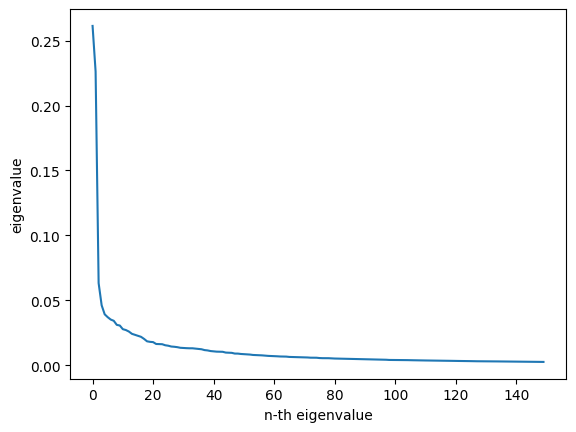

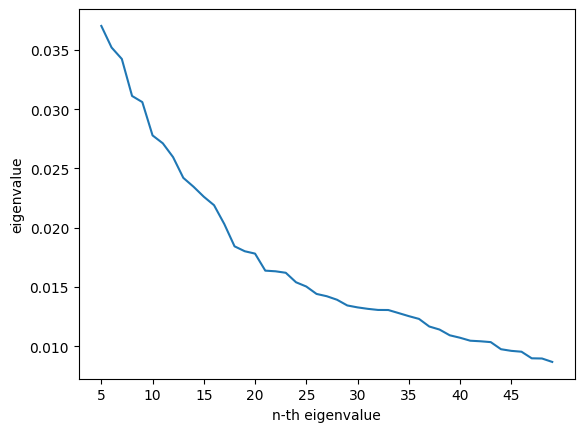

In [6]:
# choose r=22
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.plot(range(150),abs(D)[:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()
plt.plot(range(5,50),abs(D)[5:50])
plt.xticks(range(5,50,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

Text(0, 0.5, 'eigenvalue')

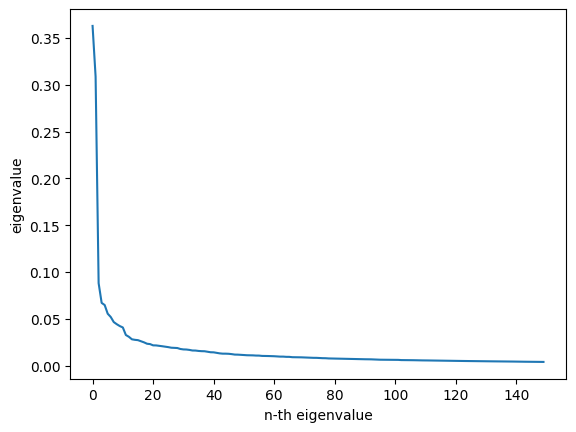

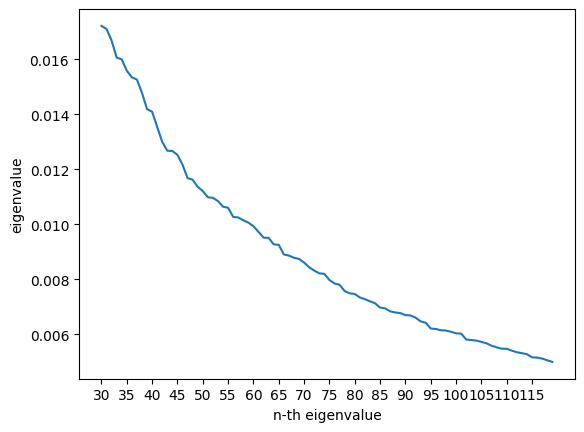

In [7]:
# choose r+l=46
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.plot(range(150),abs(D)[:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
plt.figure()

plt.plot(range(30,120),abs(D)[30:120])
plt.xticks(range(30,120,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

In [5]:
def score(index):
    count=0
    for i in index:
        if i<15:
            count+=1
    return count


In [3]:
# adapt the cICA function to output also lambda and lambda' 
def recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=None,r=None,l=None):
    I=k4_b.shape[0]
    if r==None:
        # get flattening of k4_b
        matK4b=k4_b.reshape(I**2,I**2)
        # remove repeat entries from matK
        symind, findsym, symindscale = symmetric_indices(I, 2)
        symindscale = np.sqrt(symindscale)
        findsym = findsym.flatten()
        symind = symind[::-1,:].T @ (I ** np.arange(2))
        sym_matK4b = symindscale.reshape(1, -1) * matK4b[symind][:, symind] * symindscale.reshape(-1, 1)
        D_prime,symV_prime=eig2(sym_matK4b)
        eigtol= 1e-12
        rank_k4_b=D_prime.shape[0]-np.searchsorted(abs(D_prime[::-1]), eigtol)
        # r=min(rank_k4_b,I)
        r=rank_k4_b
    
    # recover the a_i vectors (backgroud patterns) & prevent repetitive vectors
    a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
    first_residule=return_residual(k4_b,a_s,lambdas)/(I**4)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,max(distancebewteenvectors(cols[:,i],cols[:,j]),distancebewteenvectors(cols[:,i],-cols[:,j])))
        return error
    step=0
    if step_max==None:
        step_max=100
    while returnmindistancebewteenvectors(a_s)<0.1 and step<step_max:
        a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
        step+=1
    # print('step',step)
    
    # get flattening of k4_f,k4_b
    k4_f_copy=k4_f.copy()
    matK4f=k4_f_copy.reshape(I**2,I**2)

    # remove repeat entries from matK
    symind, findsym, symindscale = symmetric_indices(I, 2)
    symindscale = np.sqrt(symindscale)
    findsym = findsym.flatten()
    symind = symind[::-1,:].T @ (I ** np.arange(2))
    sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
    D, symV = eig2(sym_matK4f)
    eigtol= 1e-12
    rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
    D = D[:rank_k4_f]
    V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
    D1 = np.diagflat(1. / D).T
    # learn coefficients of a_i in k4_f
    lambda_prime=[]
    for a in a_s.T:
        apow = khatri_rao_power(a.reshape(-1, 1), 2)
        alpha = (apow.T @ V).T
        D1alpha = D1 @ alpha
        scalar=(alpha.T @ D1alpha)[0,0]
        k4_f_copy-=(1. / scalar)*generate_lowrank_tensor(a.reshape(-1,1),4)
        lambda_prime.append(1./scalar)
        matK4f=k4_f_copy.reshape(I**2,I**2)
        sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
        D, symV = eig2(sym_matK4f)
        eigtol= 1e-12
        rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
        D = D[:rank_k4_f]
        V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
        D1 = np.diagflat(1. / D).T
    if l==None:
        l=rank_k4_f
        print('l',l)
    
    Diag,B=eig2(k4_f_copy.reshape(I**2,I**2))
    D_foreground=Diag
    M=k4_f_copy.reshape(I**2,I**2)
    blist=[]
    eigen_list = []
    for n,bpow in enumerate(B.T[:l]):
        bpowmat=bpow.reshape(I,I)
        Diag_prime,eigen=eig2(bpowmat)
        b=eigen[:,0].flatten()
        eigen_list.append(Diag_prime[0])
        blist.append(b/np.sum(b*b)**0.5)
        bpow=Diag_prime[0]*khatri_rao_power(b.reshape(-1, 1), 2)
        M-=Diag[n]*bpowmat.reshape(-1,1)@bpowmat.reshape(1,-1)
    # print((np.array(eigen_list)**2)*Diag[:l])
    blist=np.array(blist).T
    second_residule=np.sum(M*M)/(I**4)
    # rank b_i according to their variance ratio
    contrastvarlist=[]
    fore_varlist=[]
    back_varlist=[]
    for b in blist.T:
        b=b.reshape(-1,1)
        fore_var=(b.T@ k2_f @ b).flatten()
        back_var=(b.T@k2_b @ b).flatten()
        # varlist.append(fore_var)
        contrastvarlist.append(fore_var/back_var)
        fore_varlist.append(fore_var)
        back_varlist.append(back_var)

    contrastind=(-np.array(contrastvarlist)).flatten().argsort().tolist()
    b_s_sorted_contrast= blist[:,contrastind]
    return a_s,b_s_sorted_contrast,np.array(contrastvarlist).flatten()[contrastind],first_residule,second_residule,D_foreground,lambda_prime,lambdas

In [6]:
#cICA
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residule,D_foreground,lambda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=22,l=46-22)
cumulant_ratio = abs(np.array(lambda_prime)/lambdas)
cumulant_ratio.max(),cumulant_ratio.min(),lambda_prime,cumulant_ratio

[ 2.36394297  0.49120319  0.26663876  0.09876182 -0.10214514 -0.06428277
  0.04633784 -0.03119251  0.03047352  0.02347887  0.01754751  0.01173918
 -0.02059255  0.0129068   0.01125321 -0.01428573  0.01067382  0.00817706
 -0.00714972  0.00666811  0.00610148  0.00737712 -0.00647577  0.00543851]


(55.43939728777803,
 0.04621915703055911,
 [-0.08929890491567993,
  -0.18888987014230538,
  0.022821103619303913,
  -0.06804900995919688,
  -0.005356932597324881,
  0.02682687920226756,
  0.05056148881753851,
  -2.2671778692921487,
  0.02977978927484524,
  0.13189495050759256,
  -0.005855278269262368,
  0.009722636736914198,
  -0.0022456941543349137,
  0.02498785770107017,
  -0.01083911451899136,
  -0.030745692131024297,
  0.02506419553911739,
  0.011165803076185102,
  0.007391515061002643,
  0.04071508067375106,
  0.156296528052083,
  0.01754694303886031],
 array([5.62863331e-01, 7.98030505e-01, 1.41054197e-01, 7.76520867e-01,
        8.04589759e-02, 5.14420622e-01, 1.40076373e+00, 5.54393973e+01,
        7.12680126e-01, 3.34063046e+00, 8.01613821e-02, 2.01766205e-01,
        4.62191570e-02, 8.93262235e-01, 1.24274966e-01, 1.04407284e+00,
        7.17085372e-01, 2.67995607e-01, 1.93431982e-01, 9.29387301e-01,
        2.68640073e+00, 3.67519176e-01]))

In [23]:
#cICA
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residule,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=22,l=46-22)
index_1=np.argsort(abs(b_s_sorted[:,0]))[-15:]
index_2=np.argsort(abs(b_s_sorted[:,1]))[-15:]
score(index_1),score(index_2),index_1,index_2


(10,
 13,
 array([ 0,  1, 19, 28, 26,  3, 23, 11, 10,  5, 18,  2,  4, 13, 12]),
 array([ 8, 14, 10,  5,  4,  6,  3, 11,  1,  2, 28, 18, 13, 12,  0]))

In [17]:
set(index_1).union(set(index_2))

{0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 18, 19, 23, 26, 28}

In [7]:
#ICA
np.random.seed(0)
a_s,b_s_sorted_ICA,coeff,first_residual,second_residule,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=0,l=46)
index_1=np.argsort(abs(b_s_sorted_ICA[:,0]))[-15:]
index_2=np.argsort(abs(b_s_sorted_ICA[:,1]))[-15:]
score(index_1),score(index_2),set(index_1).union(set(index_2))

(9, 10, {0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 23, 26})

In [12]:
l=[]
for n in b_s_sorted[:,0]:
    l.append(round(n,3))
np.array(l)

array([-0.04 , -0.041, -0.09 , -0.051, -0.12 ,  0.075,  0.01 , -0.004,
        0.002,  0.007, -0.07 , -0.061,  0.95 ,  0.192, -0.009, -0.007,
       -0.002, -0.001, -0.076, -0.042, -0.008, -0.04 ,  0.005, -0.058,
        0.012, -0.012, -0.05 , -0.006, -0.046, -0.005])

In [13]:
l=[]
for n in b_s_sorted[:,1]:
    l.append(round(n,3))
np.array(l)

array([ 0.615, -0.166,  0.185,  0.119,  0.113, -0.099, -0.118,  0.011,
        0.045, -0.025,  0.098,  0.141, -0.482, -0.339,  0.054,  0.028,
       -0.005,  0.03 ,  0.247, -0.017, -0.031,  0.043,  0.012,  0.043,
        0.015,  0.04 ,  0.025,  0.002,  0.236, -0.016])

In [24]:
#PCPCA choose gamma
score_list_1=[]
score_list_2=[]
score_list_3=[]
score_list_4 = []
b_list=[]
n, m = X.shape[0], Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
    X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
    b=pcpca.W_mle
    b_list.append(b)
    score_list_1.append(score(np.argsort(abs(b[:,0]))[-15:]))
    score_list_2.append(score(np.argsort(abs(b[:,1]))[-15:]))
    score_list_3.append(score(np.argsort(abs(b[:,0]))[-15:])+score(np.argsort(abs(b[:,1]))[-15:]))
    score_list_4.append(score(set(np.argsort(abs(b[:,0]))[-15:]).union(set(np.argsort(abs(b[:,1]))[-15:]))))

print(max(score_list_1),max(score_list_2),max(score_list_3))
index=np.argmax(np.array(score_list_3))
gamma=np.linspace(0,0.9,100)[index]
print(gamma)

10 11 21
0.0


In [9]:
# PCPCA
gamma = 0
n, m = X.shape[0], Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
b=pcpca.W_mle
np.argsort(abs(b[:,0]))[-15:],np.argsort(abs(b[:,1]))[-15:],set(np.argsort(abs(b[:,0]))[-15:]).union(set(np.argsort(abs(b[:,1]))[-15:]))


(array([12, 19, 23, 18, 10,  2, 17,  1,  3, 28, 11,  5,  4, 13,  6]),
 array([23,  8, 26, 29, 11, 10,  0,  4,  2,  1,  3, 28,  5,  6, 13]),
 {0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 17, 18, 19, 23, 26, 28, 29})

In [32]:
# cPCA choose alpha
k2_f = np.cov(X,rowvar=False)
k2_b = np.cov(Y,rowvar=False)
#cPCA
mdl=CPCA()
score_list_1=[]
score_list_2=[]
score_list_3=[]
alphas = np.logspace(-3,3,100)
for alpha in alphas:
    D,V=np.linalg.eig(k2_f-alpha*k2_b)
    eig_idx = np.argpartition(D, -2)[-2:]
    b_cpca=V[:,eig_idx]
    score_list_1.append(score(np.argsort(abs(b_cpca[:,0]))[-15:]))
    score_list_2.append(score(np.argsort(abs(b_cpca[:,1]))[-15:]))
    score_list_3.append(score(np.argsort(abs(b_cpca[:,0]))[-15:])+score(np.argsort(abs(b_cpca[:,1]))[-15:]))
    score_list_4.append(score(set(np.argsort(abs(b_cpca[:,0]))[-15:]).union(set(np.argsort(abs(b_cpca[:,1]))[-15:]))))
print(max(score_list_1),max(score_list_2),max(score_list_3),max(score_list_4))
alpha=alphas[np.argmax(score_list_3)]
alpha

10 10 20 12


(0.1747528400007685, 0.001)

In [15]:
#cPCA
alpha=0.1747528400007685
D,V=np.linalg.eig(k2_f-alpha*k2_b)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
cpca_top_15= np.argsort(abs(b_cpca[:,0]))[-15:]
cpca_top_15_2= np.argsort(abs(b_cpca[:,1]))[-15:]
cpca_top_15, cpca_top_15_2, set(cpca_top_15).union(set(cpca_top_15_2))



(array([ 0, 19, 26, 13,  2,  3, 23, 10, 17, 11, 18,  4,  5,  6, 12]),
 array([15, 24, 28,  9, 12,  1,  3,  2,  0, 29, 17,  5,  6,  4, 13]),
 {0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 17, 18, 19, 23, 24, 26, 28, 29})

In [27]:
# hierachical tensor decomp of k4_f-gamma k4_b, choose gamma
score_list_1=[]
score_list_2=[]
score_list_3=[]
score_list_4=[]
for gamma in np.logspace(-3,3,num=100):
    gamma=gamma**2 
    b_s_sorted_proportional,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,46-22)
    score_list_1.append(score(np.argsort(abs(b_s_sorted_proportional[:,0]))[-15:]))
    score_list_2.append(score(np.argsort(abs(b_s_sorted_proportional[:,1]))[-15:]))
    score_list_3.append(score(np.argsort(abs(b_s_sorted_proportional[:,0]))[-15:])+score(np.argsort(abs(b_s_sorted_proportional[:,1]))[-15:]))
    score_list_4.append(score(set(np.argsort(abs(b_s_sorted_proportional[:,0]))[-15:]).union(set(np.argsort(abs(b_s_sorted_proportional[:,1]))[-15:]))))
index=np.argmax(score_list_3)
gamma=(np.logspace(-3,3,num=100)[index])**2
print(gamma)
b_s_sorted_proportional,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,46-22)
index_1=np.argsort(abs(b_s_sorted_proportional[:,0]))[-15:]
index_2=np.argsort(abs(b_s_sorted_proportional[:,1]))[-15:]
score(index_1),score(index_2),set(index_1).union(set(index_2))

0.030538555088334193


(10, 10, {0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 17, 18, 19, 21, 23, 26})

In [29]:
# hierachical tensor decomp of k4_f-gamma k4_b
gamma=0.030538555088334193
b_s_sorted_proportional,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,46-22)
index_1=np.argsort(abs(b_s_sorted_proportional[:,0]))[-15:]
index_2=np.argsort(abs(b_s_sorted_proportional[:,1]))[-15:]
score(index_1),score(index_2),set(index_1).union(set(index_2))

(10, 10, {0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 17, 18, 19, 21, 23, 26})

In [16]:
# check similarities of learned patterns by different methods
def inner_products(a,b):
    inner_list = []
    index_list  = [[0,0],[0,1],[1,0],[1,1]]
    for index in index_list:
        index_1=index[0]
        index_2=index[1]
        inner_list.append(np.sum(a[:,index_1]*b[:,index_2]))
    return inner_list



In [39]:
b[:,0]=b[:,0]/np.linalg.norm( b[:,0])
b[:,1]=b[:,1]/np.linalg.norm( b[:,1])

print("ICA vs cICA")
print(inner_products(b_s_sorted,b_s_sorted_ICA))

print("ICA vs proportional cICA")
print(inner_products(b_s_sorted,b_s_sorted_proportional))

print("cPCA vs cICA")
print(inner_products(b_s_sorted,b_cpca))

print("PCPCA vs cICA")
print(inner_products(b_s_sorted,b))

print("PCA vs cICA")
print(inner_products(b_s_sorted,b_pca))


## first pattern of cICA quite close to second pattern of ICA and proportional ICA (inner product 0.99, the other inner product 0.64)
## first pattern of cICA not far away from first pattern of PCA and cPCA (inner product 0.8)


ICA vs cICA
[-0.668855390399274, -0.9968363561264341, 0.025875235422560487, 0.641827426142069]
ICA vs proportional cICA
[-0.6408546254455783, -0.9967019927308355, 0.08671779497445169, 0.6424576598014737]
cPCA vs cICA
[-0.8547722370613999, -0.18971594813243575, 0.6618500255629011, 0.3246869082987784]
PCPCA vs cICA
[0.07641450771824088, 0.15683660088976684, -0.09544899055252959, -0.28690928110422614]
PCA vs cICA
[-0.8059595981802417, -0.18965621966572488, 0.6465200190709288, 0.324588777502115]
